In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from scipy.interpolate import RectBivariateSpline
from datetime import datetime, timedelta
from scipy import stats
from matplotlib.lines import Line2D
import geopandas

import glob

import sys
sys.path.append('../')
import plotting
import utils

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

In [2]:
ds = xr.open_zarr('./model_NEI_egrid_GC_ds.zarr')
#import dataset with the SO4 and NIT contributions from the model
PM_ds = xr.open_zarr('./pm_ds.zarr')

#molecular weights of species
mw_species = {
    'NH4': 18.,
    'NIT': 62.,
    'SO4': 96.,
    'BCPI': 12.,
    'OCPI': 12.,
    'BCPO': 12.,
    'OCPO': 12.,
    'DST1': 29.,
    'DST2': 29.,
    'SALA': 31.4,
}
#list of pm species
pm_species = list(mw_species.keys())

PM_ds = utils.ppb_to_ug(PM_ds, pm_species, mw_species)


ds = xr.merge([ds, PM_ds])

ValueError: group not found at path ''

In [ ]:
utils.lat_lon_dict['US_lat_lon']

### Import Dataframes of Interpolated and EPA Data

In [4]:
interp_EPA_df = pd.read_csv('./interp_EPA_df.csv', parse_dates = True)
EPA_obs_df = pd.read_csv('./EPA_obs_df.csv', parse_dates = True)
EPA_monthly_df = pd.read_csv('./EPA_monthly_obs_df.csv', parse_dates = True)
interp_EPA_df = interp_EPA_df.rename(columns = {'Latitude':'latitude','Longitude':'longitude'})

IMPROVE_obs_df = pd.read_csv('./IMPROVE_df.csv', parse_dates = True)
interp_IMPROVE_df = pd.read_csv('./interp_IMPROVE_df.csv', parse_dates = True)
IMPROVE_monthly_df = pd.read_csv('./IMPROVE_monthly_obs_df.csv', parse_dates = True)
interp_IMPROVE_df = interp_IMPROVE_df.rename(columns = {'Latitude':'latitude','Longitude':'longitude'})

#change to datetime
interp_EPA_df['date'] = pd.to_datetime(interp_EPA_df['date'])
EPA_obs_df['date'] = pd.to_datetime(EPA_obs_df['date'], format='%Y%m%d')
EPA_monthly_df['date'] = pd.to_datetime(EPA_monthly_df['date'], format = '%Y%m%d')
IMPROVE_obs_df['date'] = pd.to_datetime(IMPROVE_obs_df['Date'], format = '%Y%m%d')
interp_IMPROVE_df['date'] = pd.to_datetime(interp_IMPROVE_df['date'])
IMPROVE_monthly_df['date'] = pd.to_datetime(IMPROVE_monthly_df['date'], format = '%Y%m%d')

#select only Lat and Lon on continental US
EPA_obs_df = EPA_obs_df.loc[(EPA_obs_df['Latitude'].between(24,50,inclusive = True)) & (EPA_obs_df['Longitude'].between(-130,-60,inclusive = True))]
EPA_monthly_df = EPA_monthly_df.loc[(EPA_monthly_df['latitude'].between(24,50,inclusive = True)) & (EPA_monthly_df['longitude'].between(-130,-60,inclusive = True))]
interp_EPA_df = interp_EPA_df.loc[(interp_EPA_df['Latitude'].between(24,50,inclusive = True)) & (interp_EPA_df['Longitude'].between(-130,-60,inclusive = True))]
IMPROVE_obs_df = IMPROVE_obs_df.loc[(IMPROVE_obs_df['Latitude'].between(24,50,inclusive = True)) & (IMPROVE_obs_df['Longitude'].between(-130,-60,inclusive = True))]
interp_IMPROVE_df = interp_IMPROVE_df.loc[(interp_IMPROVE_df['Latitude'].between(24,50,inclusive = True)) & (interp_IMPROVE_df['Longitude'].between(-130,-60,inclusive = True))]
IMPROVE_monthly_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['latitude'].between(24,50,inclusive = True)) & (IMPROVE_monthly_df['longitude'].between(-130,-60,inclusive = True))]


### Lists/Dicts of Variables

In [5]:
#define Lat and Lon of the nested grid US
model_names = ['egrid','NEI','MODEL']

levels_dict = {'PM25':np.arange(0., 51, 1), 'SO2':np.arange(0., 5., .1), 
               'NO2':np.arange(0., 5., .1), 'NOx':np.arange(0., 5., .1), 'O3':np.arange(0., 70., 1.),
               'dif':np.arange(-.3, .31, .01), 'regional_dif':np.arange(-1.5, 1.51, .01)}
colors_dict = {'egrid':'xkcd:scarlet', 'NEI':'xkcd:bluish','MODEL':'xkcd:forest green'}

### Dictionary of Differences between Interpolation and Observations

In [6]:
EPA_interp_dif = utils.interp_obs_differences(EPA_obs_df, interp_EPA_df, utils.month_string, model_names,['PM25', 'SO2', 'NO2', 'O3'])
IMPROVE_interp_dif = utils.interp_obs_differences(IMPROVE_obs_df, interp_IMPROVE_df, utils.month_string, model_names, ['NIT','SO4','PM25'])

# Plots 

In [7]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_string = utils.month_string
cmap_conc = 'pink_r'
cmap_dif = 'BrBG_r'


### Differences between Observations and each GC Run

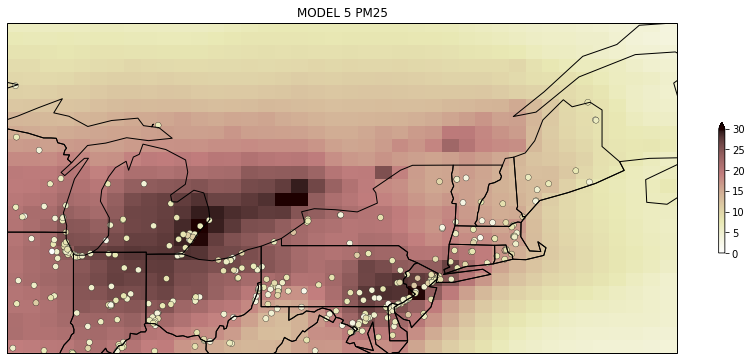

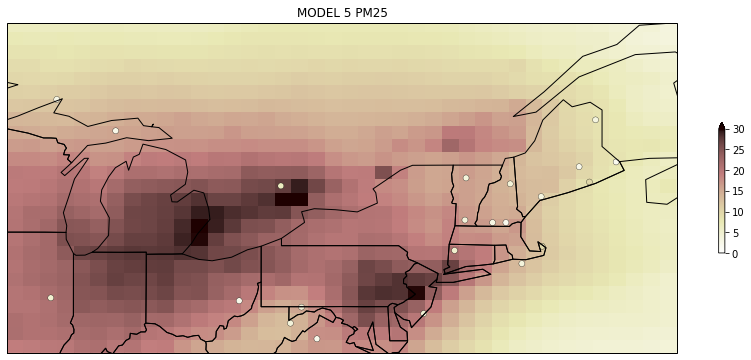

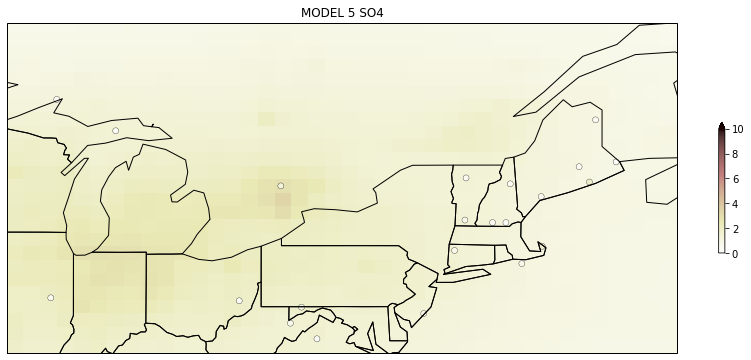

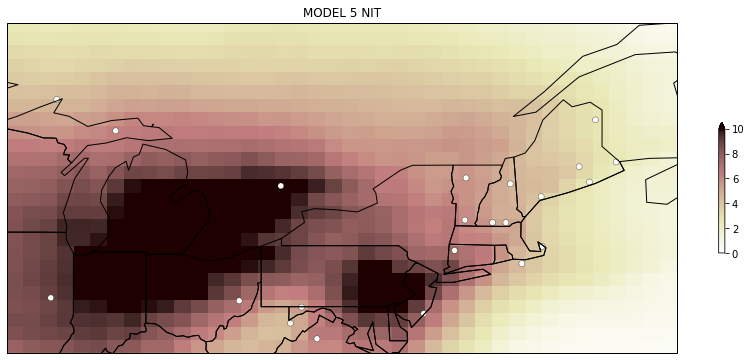

In [8]:
plotting.obs_model_plot(ds, EPA_obs_df, species = 'PM25',model_names = ['MODEL'],
               cmap = cmap_conc, figsize = [15,8],month = 5,
               vmin = 0, vmax = 30, 
               rows = 1, columns = 1, lat_lon = utils.lat_lon_dict['NE_lat_lon'])

plotting.obs_model_plot(ds, IMPROVE_obs_df, species = 'PM25',model_names = ['MODEL'],
               cmap = cmap_conc, figsize = [15,8],month = 5,
               vmin = 0, vmax = 30, 
               rows = 1, columns = 1, lat_lon = utils.lat_lon_dict['NE_lat_lon'])

plotting.obs_model_plot(ds, IMPROVE_obs_df, species = 'SO4',model_names = ['MODEL'],
               cmap = cmap_conc, figsize = [15,8],month = 5,
               vmin = 0, vmax = 10, 
               rows = 1, columns = 1, lat_lon = utils.lat_lon_dict['NE_lat_lon'])

plotting.obs_model_plot(ds, IMPROVE_obs_df, species = 'NIT',model_names = ['MODEL'],
               cmap = cmap_conc, figsize = [15,8],month = 5,
               vmin = 0, vmax = 10, 
               rows = 1, columns = 1, lat_lon = utils.lat_lon_dict['NE_lat_lon'])


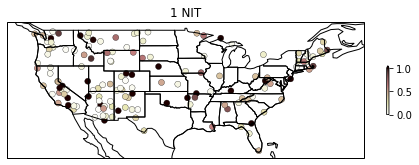

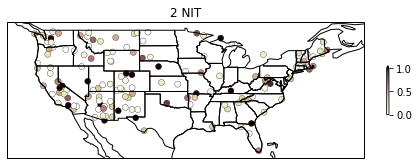

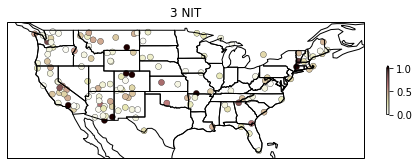

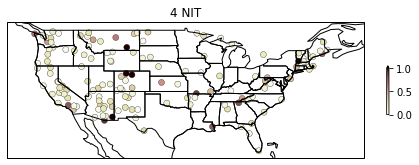

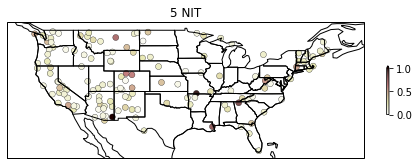

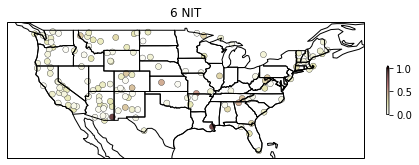

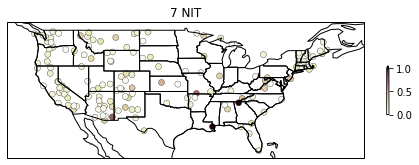

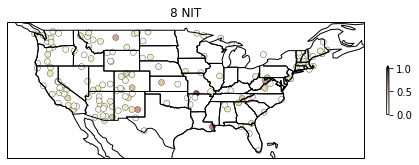

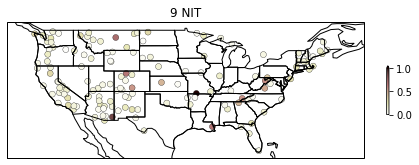

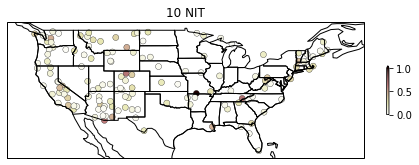

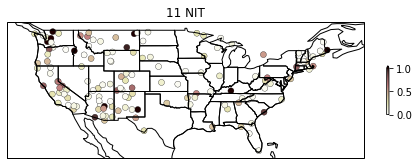

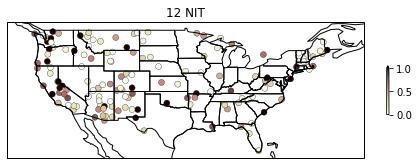

In [9]:
for month in range(1,13):
    plotting.obs_plot(IMPROVE_obs_df,'NIT',month, 0, 1, cmap_conc, figsize = [8,3], lat_lon = utils.lat_lon_dict['US_lat_lon'])

TypeError: 'GeoAxesSubplot' object is not subscriptable

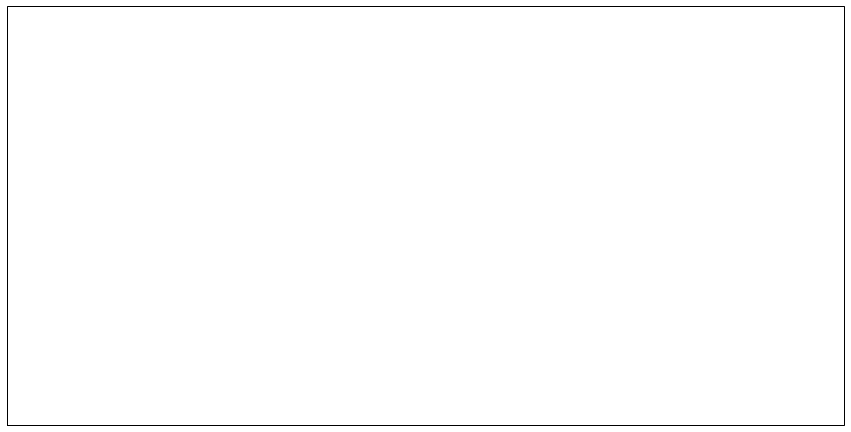

In [14]:
plotting.concentration_plot_annual(ds, species_names = ['PM25'], model_names = ['MODEL'],
                   rows = 1, columns = 1, lat_lon = utils.lat_lon_dict['US_lat_lon'],
                    levels = np.arange(0,30,1),figsize = [15,8], cmap = cmap_conc, shrink_cbar = .5)
plt.annotate(s = 'NEI, Egrid, and EGO Model PM 2.5 Concentrations', xy = (0.3,0.85), xycoords = 'figure fraction', fontsize = 16);

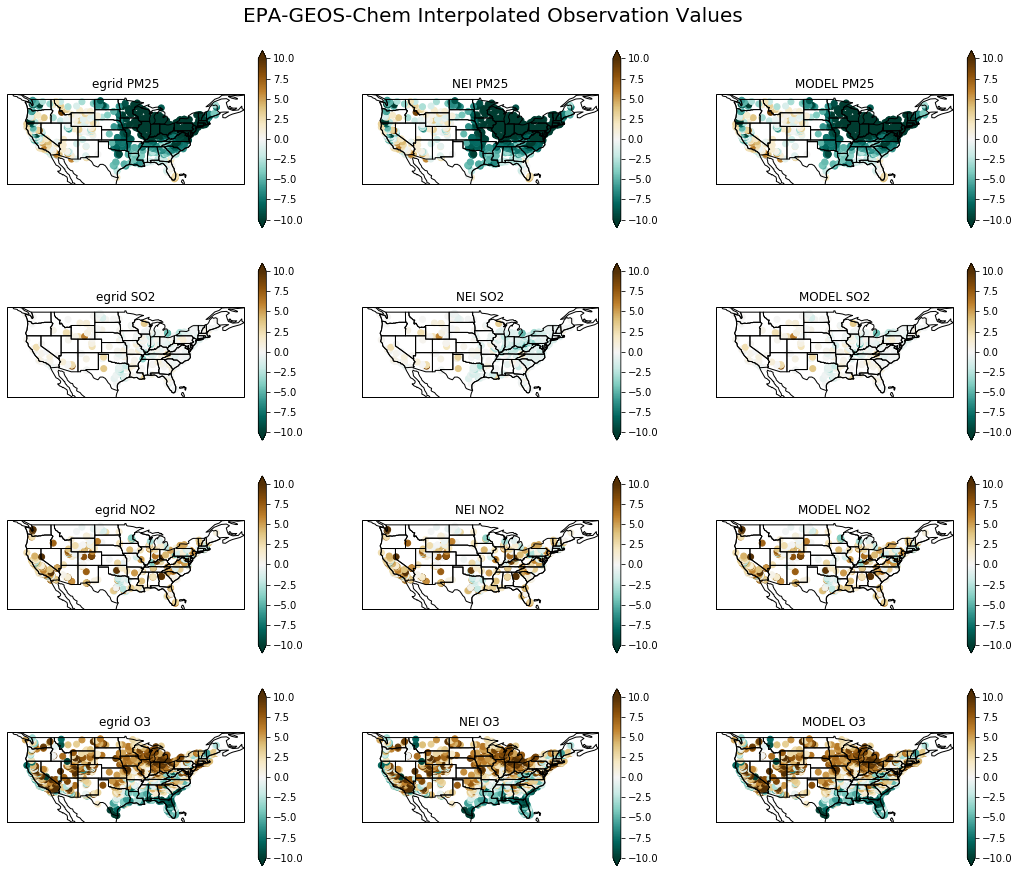

In [15]:
fig, axes = plt.subplots(4,3,figsize = [18,15],subplot_kw={'projection': ccrs.PlateCarree()})
for idx_s, species in enumerate(['PM25', 'SO2', 'NO2', 'O3']):
    for idx_m, model in enumerate(model_names):
        ax = axes[idx_s,idx_m] 
        lat_o = EPA_interp_dif[species][model].reset_index()['Latitude']
        lon_o = EPA_interp_dif[species][model].reset_index()['Longitude']
        c = EPA_interp_dif[species][model].reset_index()['Arithmetic Mean']
        PCM_o = ax.scatter(lon_o, lat_o, c = c, transform = ccrs.PlateCarree(), cmap = cmap_dif, vmin = -10, vmax = 10)
        plt.colorbar(PCM_o, ax=ax,extend='both', cmap = cmap_dif) 
        ax.coastlines()
        ax.add_feature(cfeat.STATES)
        ax.set_extent(utils.lat_lon_dict['US_lat_lon'])
        ax.set_title(f'{model} {species}')
plt.suptitle('EPA-GEOS-Chem Interpolated Observation Values', fontsize = 20, y = .92);

# Linear Regression and Scatterplots

## Scatterplots of interpolation

In [16]:
### linear regression on our data (EPA vs GC model runs)
lin_regress_EPA_df = utils.linregress_data(EPA_obs_df, interp_EPA_df, model_names, month_string, ['PM25', 'SO2', 'NO2', 'O3'])
lin_regress_IMPROVE_df = utils.linregress_data(IMPROVE_obs_df, interp_IMPROVE_df, model_names, month_string, ['NIT','PM25','SO4'])

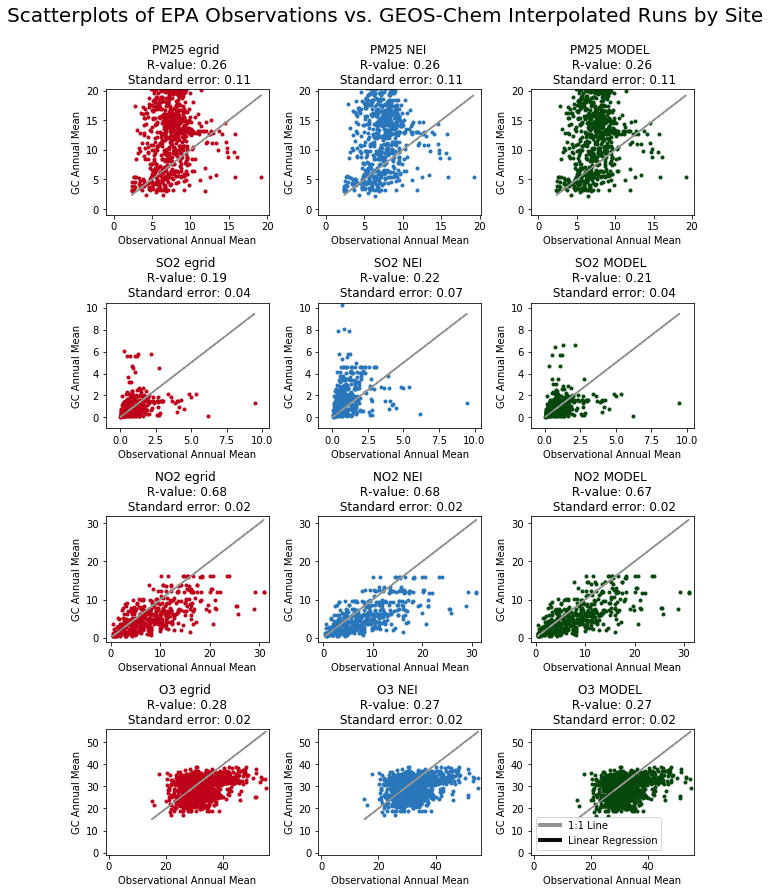

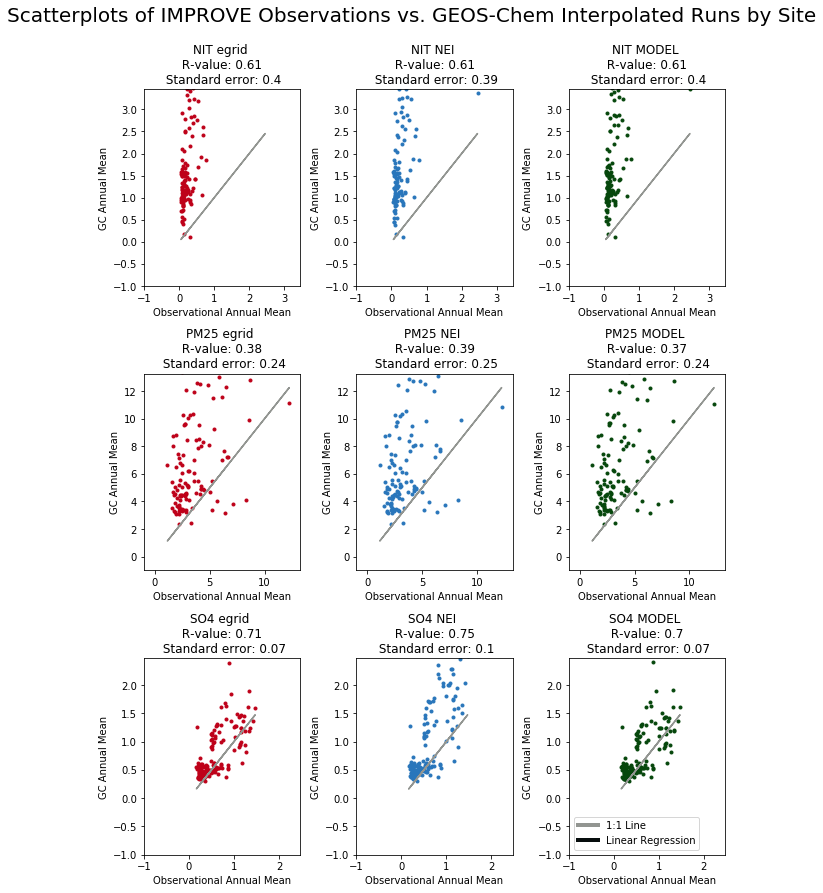

In [17]:
plotting.interp_scatterplot(interp_EPA_df, EPA_obs_df, lin_regress_EPA_df, ['PM25', 'SO2', 'NO2', 'O3'], 
                            model_names = model_names, month_string = month_string, colors_dict = colors_dict,
                           rows = 4, columns = 3)
plt.suptitle('Scatterplots of EPA Observations vs. GEOS-Chem Interpolated Runs by Site', fontsize = 20, y = 1.03);

plotting.interp_scatterplot(interp_IMPROVE_df, IMPROVE_obs_df, lin_regress_IMPROVE_df, 
                            ['NIT','PM25','SO4'], model_names = model_names, month_string = month_string, colors_dict = colors_dict,
                           rows = 3, columns = 3)
plt.suptitle('Scatterplots of IMPROVE Observations vs. GEOS-Chem Interpolated Runs by Site', fontsize = 20, y = 1.03);

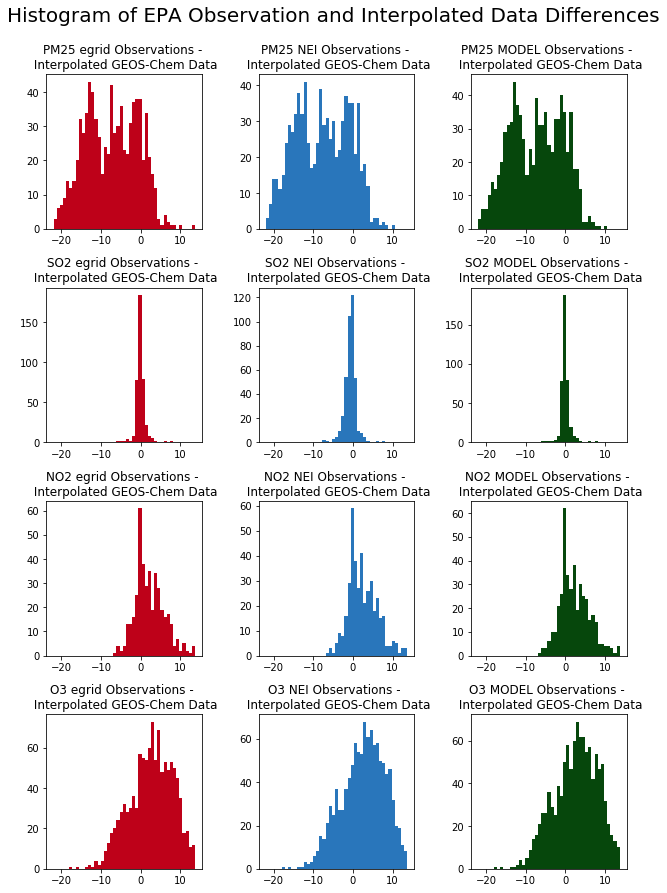

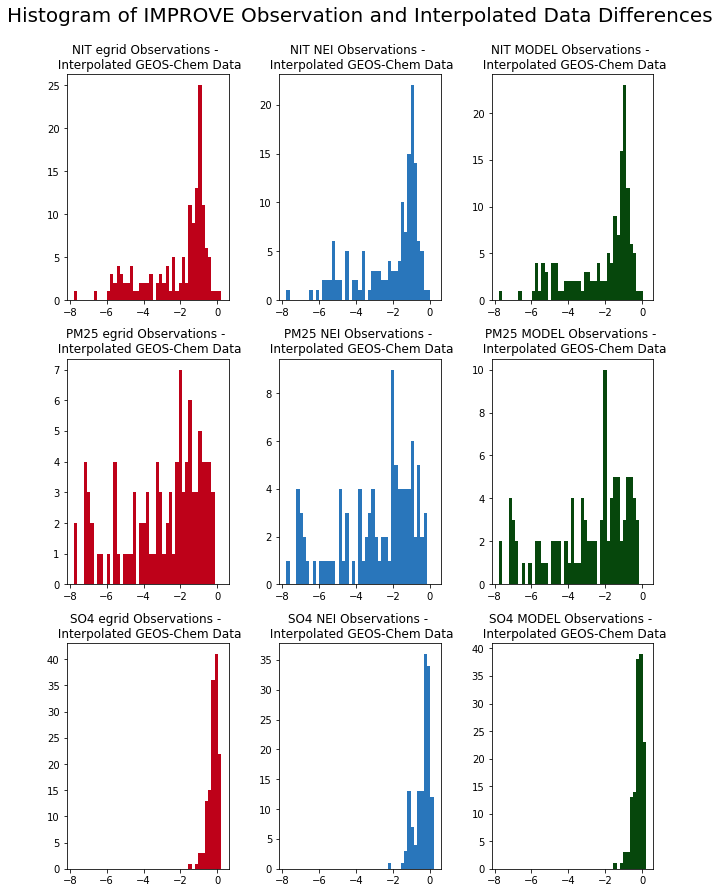

In [18]:
plotting.hist_obs_interp(EPA_interp_dif, model_names, colors_dict, bins = 45, species_list = ['PM25', 'SO2', 'NO2', 'O3'], rows = 4, columns = 3)
plt.suptitle('Histogram of EPA Observation and Interpolated Data Differences', fontsize = 20, y = 1.03);

plotting.hist_obs_interp(IMPROVE_interp_dif, model_names, colors_dict, bins = 45, species_list = ['NIT','PM25','SO4'], rows = 3, columns = 3)
plt.suptitle('Histogram of IMPROVE Observation and Interpolated Data Differences', fontsize = 20, y = 1.03);

## Group Dataframes by region and look at regional distribution of error

#### Merge Datasets

In [19]:
### merge datasets into one with region, model, species as the categories
EPA_monthly_df['model'] = 'EPA'
IMPROVE_monthly_df['model'] = 'IMPROVE'
cdf = pd.concat([EPA_monthly_df, interp_EPA_df,interp_IMPROVE_df, IMPROVE_monthly_df])   # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Region','model','species'],value_vars = ['Arithmetic Mean'])      # MELT

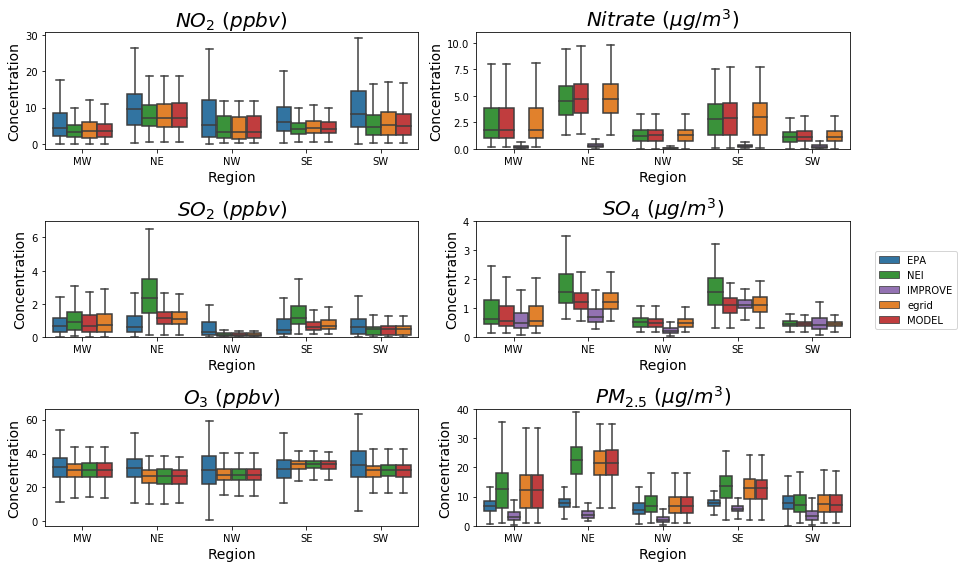

In [20]:
#create list of colors for palette
unique = mdf["model"].unique()
palette = dict(zip(unique, sns.color_palette()))

#create list of proper names for regions
region_name = ['MW','SW','NW','NE','SE']
region_dict = dict(zip(['MW_lat_lon', 'SW_lat_lon', 'NW_lat_lon', 'NE_lat_lon',
       'SE_lat_lon'],region_name))

#plot 
fig = plt.figure(figsize = [12,8])

for idx, species in enumerate(['NO2','NIT','SO2','SO4','O3','PM25']):
    ax = fig.add_subplot(3, 2, idx+1)
    q = sns.boxplot(y='value', x='Region', hue = 'model',
                     data=mdf.loc[(mdf['species'] == species)].sort_values('Region'), 
                     width=0.8,
                     palette=palette,
                     showfliers = False)
    plt.title(f'{plotting.proper_names_dict[species]}', fontsize = 20);
    #adjust ylim for different species
    if species == 'SO2':
        plt.ylim([0,7])
    if species == 'PM25':
        plt.ylim([0,40])
    if species == 'SO4':
        plt.ylim([0,4])
    if species == 'NIT':
        plt.ylim([0,11])
    ax.get_legend().set_visible(False)
    fig.tight_layout()
    #adjust title and fontsize of x and y labels
    ax.set_ylabel('Concentration', fontsize = 14)
    ax.set_xlabel('Region', fontsize = 14)
    #change labels to proper region names
    texts = [t.get_text()  for t in ax.get_xticklabels()]
    ax.set_xticklabels([region_dict[region] for region in texts])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.3, 2.4), bbox_transform=ax.transAxes);
plt.savefig('./Figures/obs_boxplots', bbox_inches = 'tight', dpi = 150)

## calculate NMB

In [ ]:
#find where the NIT data and PM data diverge and get rid of these readings in the PM data
PM_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['Region'] == 'NW_lat_lon') & (IMPROVE_monthly_df['species'] == 'PM25')]
NIT_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['Region'] == 'NW_lat_lon') & (IMPROVE_monthly_df['species'] == 'NIT')]
comparison_df = NIT_df.merge(PM_df,
                              indicator=True,
                              how='outer', on = ['geometry','date'])
PM_to_delete = comparison_df[comparison_df['_merge'] == 'right_only'].dropna(axis = 1)
PM_to_delete = PM_to_delete.rename(columns = {'Arithmetic Mean_y':'Arithmetic Mean', 'Latitude_y':'Latitude', 'Longitude_y':'Longitude','species_y':'species','Region_y':'Region','annual_T_y':'annual_T','annual_RH_y':'annual_RH','model_y':'model'})
PM_to_delete = PM_to_delete.drop(columns = '_merge')

#drop these values from the cdf
cdf = pd.concat([cdf_1, PM_to_delete]).drop_duplicates(keep=False)

In [58]:
#merge our IMPROVE data
IMPROVE_merged_df = IMPROVE_monthly_df.merge(interp_IMPROVE_df,
                              indicator=True,
                              how='outer', on = ['species','date','latitude','longitude', 'Region'])
#rename our columns
IMPROVE_merged_df = IMPROVE_merged_df.rename(columns = {'Arithmetic Mean_x': 'Observational mean', 'model_x':'observation', 
                                    'Arithmetic Mean_y':'Model mean', 'model_y':'model'})
#drop rows where observations are not taken (nans)
IMPROVE_merged_df.dropna(axis = 0)

#merge our IMPROVE data
EPA_merged_df = EPA_monthly_df.merge(interp_EPA_df,
                              indicator=True,
                              how='outer', on = ['latitude','longitude','species','Region','date'])
EPA_merged_df = EPA_merged_df.rename(columns = {'Arithmetic Mean_x': 'Observational mean', 'model_x':'observation', 
                                    'Arithmetic Mean_y':'Model mean', 'model_y':'model'})
EPA_merged_df = EPA_merged_df.dropna(axis = 0)

#calculate the difference between model and observations
EPA_merged_df['model-obs'] = EPA_merged_df['Model mean'] - EPA_merged_df['Observational mean']
IMPROVE_merged_df['model-obs'] = IMPROVE_merged_df['Model mean'] - IMPROVE_merged_df['Observational mean']

In [83]:
#make a dataframe of our normalized mean bias data by region and season and species, just for the MODEL runs
season_dict = {'DJF':[12,1,2],'JJA':[6,7,8]}
NMB_df = pd.DataFrame()
for region in IMPROVE_merged_df['Region'].unique():
    for species in IMPROVE_merged_df['species'].unique():
        for season in season_dict.keys():
            NMB = IMPROVE_merged_df.loc[(IMPROVE_merged_df['Region'] == region) & 
                                  (IMPROVE_merged_df['species'] == species) & 
                                  (IMPROVE_merged_df['model'] == 'MODEL') &
                                 (IMPROVE_merged_df['date'].dt.month.isin(season_dict[season]))]['model-obs'].sum()/IMPROVE_merged_df.loc[(IMPROVE_merged_df['Region'] == region) & 
                                  (IMPROVE_merged_df['species'] == species) & 
                                  (IMPROVE_merged_df['model'] == 'MODEL')& 
                                (IMPROVE_merged_df['date'].dt.month.isin(season_dict[season]))]['Observational mean'].sum()*100
            tmp_df = pd.DataFrame({'model':'MODEL','observations':'IMPROVE','season':season, 'region': region, 'species':species,'NMB':NMB}, index = np.arange(1))
            NMB_df = NMB_df.append(tmp_df, sort =False, ignore_index = True)

    for species in EPA_merged_df['species'].unique():
        for season in season_dict.keys():
            NMB = EPA_merged_df.loc[(EPA_merged_df['Region'] == region) & 
                                  (EPA_merged_df['species'] == species) & 
                                  (EPA_merged_df['model'] == 'MODEL') &
                                 (EPA_merged_df['date'].dt.month.isin(season_dict[season]))]['model-obs'].sum()/EPA_merged_df.loc[(EPA_merged_df['Region'] == region) & 
                                  (EPA_merged_df['species'] == species) & 
                                  (EPA_merged_df['model'] == 'MODEL')& 
                                (EPA_merged_df['date'].dt.month.isin(season_dict[season]))]['Observational mean'].sum()*100
            tmp_df = pd.DataFrame({'model':'MODEL','observations':'EPA','season':season, 'region': region, 'species':species,'NMB':NMB}, index = np.arange(1))
            NMB_df = NMB_df.append(tmp_df, sort =False, ignore_index = True)

In [98]:
NMB_df.loc[NMB_df['species'] == 'O3']

,model,observations,season,region,species,NMB
10,MODEL,EPA,DJF,MW_lat_lon,O3,-6.177303
11,MODEL,EPA,JJA,MW_lat_lon,O3,-5.333922
24,MODEL,EPA,DJF,SW_lat_lon,O3,11.192890
25,MODEL,EPA,JJA,SW_lat_lon,O3,-27.443850
38,MODEL,EPA,DJF,NW_lat_lon,O3,9.559084
39,MODEL,EPA,JJA,NW_lat_lon,O3,-24.283348
52,MODEL,EPA,DJF,NE_lat_lon,O3,-20.164108
53,MODEL,EPA,JJA,NE_lat_lon,O3,-13.167123
66,MODEL,EPA,DJF,SE_lat_lon,O3,11.493388
67,MODEL,EPA,JJA,SE_lat_lon,O3,23.800658


In [97]:
(282.285669+225.226627)/2

253.756148

In [87]:
NMB_df.loc[NMB_df['species'] == 'O3']

,model,observations,season,region,species,NMB
10,MODEL,EPA,DJF,MW_lat_lon,O3,-6.177303
11,MODEL,EPA,JJA,MW_lat_lon,O3,-5.333922
24,MODEL,EPA,DJF,SW_lat_lon,O3,11.192890
25,MODEL,EPA,JJA,SW_lat_lon,O3,-27.443850
38,MODEL,EPA,DJF,NW_lat_lon,O3,9.559084
39,MODEL,EPA,JJA,NW_lat_lon,O3,-24.283348
52,MODEL,EPA,DJF,NE_lat_lon,O3,-20.164108
53,MODEL,EPA,JJA,NE_lat_lon,O3,-13.167123
66,MODEL,EPA,DJF,SE_lat_lon,O3,11.493388
67,MODEL,EPA,JJA,SE_lat_lon,O3,23.800658
